In [1]:
import torch
from torch import nn, optim
from DataLoader import CIFAR10DataLoader
import hyperparams as hp
from SpectralNorm import SpecNorm
from Discriminator import Discriminator
from Generator import Generator
from math import log
from tensorboardX import SummaryWriter
import os
from random import randint
from Attention import AttentionMech

from PIL import Image
from torchvision import transforms
import matplotlib.pyplot as plt

In [2]:
"""
TO DO:
Discriminator projection
use PyTorch utils specnorm
spec norm on everything (inc embeddings)
attention
rewrite so res connections are v clear
minibatch std div?
put losses in a seperate func
We use C¯ = C/8 in all our experiments.
Bigger
Transformer attention
"""

'\nTO DO:\nDiscriminator projection\nuse PyTorch utils specnorm\nspec norm on everything (inc embeddings)\nattention\nrewrite so res connections are v clear\nminibatch std div?\nput losses in a seperate func\nWe use C¯ = C/8 in all our experiments.\nBigger\nTransformer attention\n'

In [10]:
root_log_dir='/home/sam/experiments/SAGAN/logs/'
exp_dir = 'Overtrain_Attn_DisGen'
exp_path = os.path.join(root_log_dir, exp_dir)
if not os.path.exists(exp_path):
    os.mkdir(exp_path)
    
writer = SummaryWriter(exp_path)

In [11]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [12]:
def get_im(data):
    im = (data * 0.5) + 0.5
    im = transforms.ToPILImage()(im)
    return im

In [25]:
generator = Generator()
discriminator = Discriminator()

if hp.use_cuda:
    generator = generator.cuda()
    discriminator = discriminator.cuda()

In [20]:
optimizer_g = optim.Adam(generator.parameters(), lr = 0.0001, betas=(0,0.9))
optimizer_d = optim.Adam(discriminator.parameters(), lr = 0.0004, betas=(0.0,0.9))

In [21]:
dl = CIFAR10DataLoader(hp.bs)

In [ ]:
for epoch in range(hp.train_epochs):
    print(epoch)
    for i, data in enumerate(dl):
        
        step_no = (epoch*len(dl))+i
        
        real_ims = data['image']
        real_cls = data['labels']
        lv = torch.Tensor(hp.bs,hp.latent_space_dim, 1, 1)
        lv = lv.normal_()
        #gen_cls = torch.tensor(randint(0,hp.num_classes))
        gen_cls = torch.tensor(1).repeat(hp.bs)
        
        if hp.use_cuda:
            real_ims = real_ims.cuda()
            lv = lv.cuda()
            real_cls = real_cls.cuda()
            gen_cls = gen_cls.cuda()
            
        gen_ims = generator(lv, gen_cls)
        
        # Use hinge loss
        d_fake_score = nn.ReLU()(1.0 + discriminator(gen_ims, gen_cls))
        d_real_score = nn.ReLU()(1.0 - discriminator(real_ims, real_cls))
        loss_d = d_fake_score.mean() + d_real_score.mean()
        optimizer_d.zero_grad()
        loss_d.backward()
        optimizer_d.step()
        
        gen_ims = generator(lv, gen_cls)
        loss_g = - torch.mean(discriminator(gen_ims, gen_cls))
        optimizer_g.zero_grad()
        loss_g.backward()
        optimizer_g.step()
        
        if step_no % hp.ts_log_interval == 0:
            im_to_log = (gen_ims[0] * 0.5) + 0.5
            im_file_name = 'generated_images/{}'.format(epoch)
            writer.add_image(im_file_name,im_to_log,step_no)
            writer.add_scalar('Train/Generator_loss',loss_g,step_no)
            writer.add_scalar('Train/Discriminator_loss',loss_d,step_no)

0
> /home/sam/git/SAGAN/Generator.py(28)forward()
-> x = self.block_1(x, cls)


(Pdb)  p x.shape


torch.Size([32, 512, 1, 1])


(Pdb)  n


> /home/sam/git/SAGAN/Generator.py(29)forward()
-> x = self.block_2(x, cls)


In [29]:
dl = CIFAR10DataLoader(hp.bs)
dis = Discriminator()
batch = next(iter(dl))

tensor([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
        1, 1, 1, 1, 1, 1, 1, 1])

In [31]:
dis(batch['image'])

torch.Size([32, 512, 4, 4])


tensor([[-0.0767],
        [-0.0767],
        [-0.0767],
        [-0.0767],
        [-0.0767],
        [-0.0767],
        [-0.0767],
        [-0.0767],
        [-0.0767],
        [-0.0767],
        [-0.0767],
        [-0.0767],
        [-0.0767],
        [-0.0767],
        [-0.0767],
        [-0.0767],
        [-0.0767],
        [-0.0767],
        [-0.0767],
        [-0.0767],
        [-0.0767],
        [-0.0767],
        [-0.0767],
        [-0.0767],
        [-0.0767],
        [-0.0767],
        [-0.0767],
        [-0.0767],
        [-0.0767],
        [-0.0767],
        [-0.0767],
        [-0.0767]], grad_fn=<MmBackward>)

In [177]:
lv = torch.rand(hp.bs, hp.latent_space_dim, 1, 1)

In [178]:
gen = Generator()

In [179]:
dis(gen(lv))

tensor([0.0551], grad_fn=<SqueezeBackward3>)

In [181]:
im = (batch * 0.5) + 0.5
im = transforms.ToPILImage()(im)

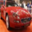

In [12]:
dl = CIFAR10DataLoader(hp.bs)
dis = Discriminator()

In [13]:
batch = next(iter(dl))['image']

In [24]:
attn = AttentionMech(100)

In [39]:
inp = torch.rand([4,100,16,16])
out=attn(inp)

In [40]:
out.shape

torch.Size([4, 100, 16, 16])

In [86]:
f,g,prod=attn(batch)

> /home/sam/git/SAGAN/Attention.py(18)forward()
-> value = self.key(x)*self.query(x)


(Pdb)  p x.shape


torch.Size([32, 3, 32, 32])


(Pdb)  p self.key(x).shaoe


*** AttributeError: 'Tensor' object has no attribute 'shaoe'


(Pdb)  p self.key(x).shape


torch.Size([32, 3, 32, 32])


(Pdb)  x self.query(x).shape


*** SyntaxError: invalid syntax


(Pdb)  p self.query(x).shape


torch.Size([32, 1024, 1024])


(Pdb)  q


BdbQuit: 

In [77]:
f.shape

torch.Size([32, 10, 1024])

In [78]:
g[0,0]

tensor([-0.3365, -0.3623, -0.3527,  ..., -0.4453, -0.4384, -0.4253],
       grad_fn=<SelectBackward>)

In [81]:
prod.shape

torch.Size([32, 1024, 1024])